# Project: Investigate a Dataset (No Show appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.

● ‘ScheduledDay’ tells us on what day the patient set up their appointment.

● ‘Neighborhood’ indicates the location of the hospital.

● ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.

● Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and 'Yes' if they did not show up.

## In this dataset we will try to solve these different questions:

1-Does Gender affect the probabilites of patients showing up or not ?

2-is being member of the brazillian welfare affect the chances of showing up ?

3-does Hypertension affect people to show up or not ?

4-does Age affect the probabilities of patients showing up or not?

5-Does the neighbourhood patients live in affect patients to not show up ?

6-Does receiving an SMS increase the chances of people showing up?

7-Does Alcohol have an influence on patients not showing up ?

8-Does Diabetes has an influence over patients not showing up?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling




### General Properties

In [2]:
# load data
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Number of Rows and Columns


In [3]:
df.shape

(110527, 14)

In [4]:
# check for duplicates and drop them if any
print(sum(df.duplicated()))


0


# Inspect Data and looking for missing data


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


There's probably a mistake with min age (-1)

Max age is 115

The mean of age is 37 years

# Cleaning the data and dropping some data that not used in analyis


In [7]:
df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'],axis=1,inplace=True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [8]:
# rename some columns and correct misspelled words
df.rename(columns={'Hipertension':'Hypertension'},inplace=True)
df.rename(columns={'No-show':'No_show'},inplace=True)
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No



## Exploratory Data Analysis




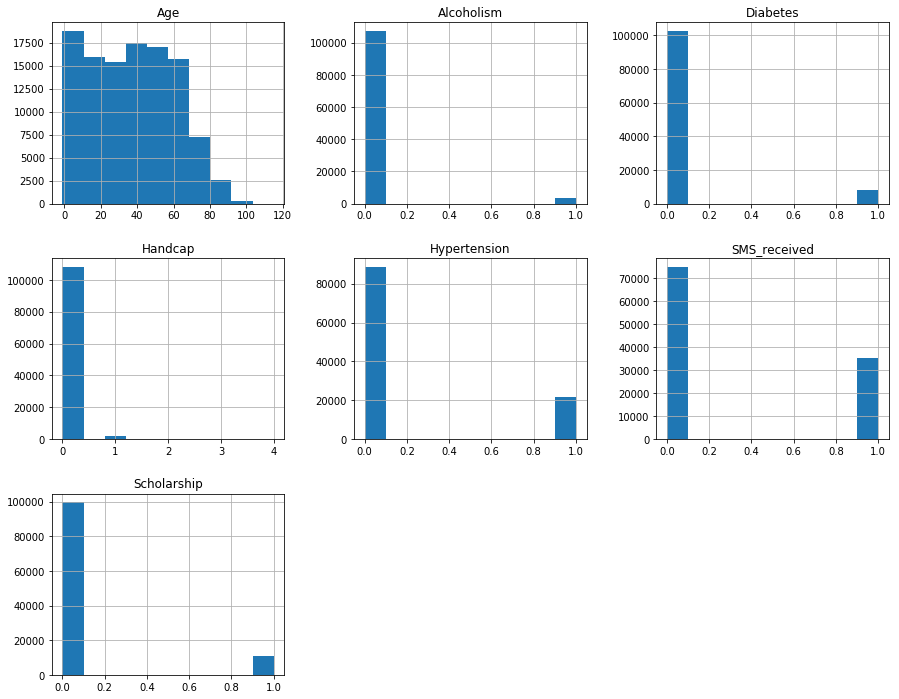

In [9]:
df.hist(figsize=(15,12));

Most of the people didn't suffer from chronic diseases

Only around 50% of the patients received Sms


In [10]:
show=df.No_show=="No"
noshow=df.No_show=="Yes"


In [13]:
df[show].count()

Gender           88208
Age              88208
Neighbourhood    88208
Scholarship      88208
Hypertension     88208
Diabetes         88208
Alcoholism       88208
Handcap          88208
SMS_received     88208
No_show          88208
dtype: int64

In [14]:
df[noshow].count()

Gender           22319
Age              22319
Neighbourhood    22319
Scholarship      22319
Hypertension     22319
Diabetes         22319
Alcoholism       22319
Handcap          22319
SMS_received     22319
No_show          22319
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

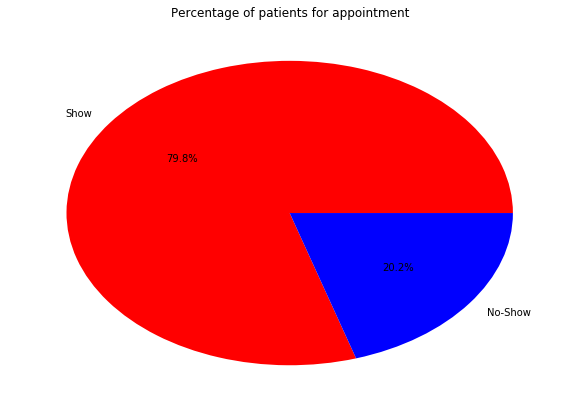

In [22]:
fig,ax=plt.subplots(figsize=(10,7))
sizes=[88208,22319]
plt.pie(sizes,autopct='%1.1f%%',colors=['Red','Blue'],labels=['Show','No-Show'])
plt.title('Percentage of patients for appointment')
plt.show

# Does Gender affect the probabilites of patients showing up or not ?


In [ ]:
def bar_plot(df,clname,show,noshow):
    plt.figure(figsize=[13,7])
    df[clname][show].hist(alpha=0.4,label='show')
    df[clname][noshow].hist(alpha=0.4,label='noshow')
    plt.legend()
    plt.title("Patients who showed up Vs patient who didn't according to "+clname)
    plt.xlabel('clname')
    plt.ylabel('Patients Number')

In [ ]:
bar_plot(df,"Gender",show,noshow)

In [ ]:
print(df.Gender[show].value_counts())
print(df.Gender[noshow].value_counts())

In [ ]:
df.groupby('Gender').No_show.value_counts()

The number of people who didn't show up is approximately 25% of who did show up and its almost same percentage for both genders so gender doesnt affect people of showing up or not !

Gender is insignificant as Females who showed up are more than males and Females that didn't show up are also more than males

# is being member of the brazillian welfare affect the chances of showing up ?


In [ ]:
bar_plot(df,"Scholarship",show,noshow)

Being enrolled in the Welfare program is insignificant and its almost the same percentage between people who didn't show up and were members to the total number of members and the people whoe didn't show up and were not members.

# Does Hypertension affect people to show up or not ?

In [ ]:
bar_plot(df,"Hypertension",show,noshow)

Having Hypertension is insignifant


# does Age affect the probabilities of patients showing up or not?


In [ ]:
bar_plot(df,"Age",show,noshow)


People in Age range (0-10) showed more than all others followed by range (35-70)

people older than 70 are less likely to get an appointment

So Age is insignificant to patients showing up or not, it's more related to patients having appointments in the first place or not

# Does the neighbourhood patients live in affect patients to not show up ?


In [ ]:
plt.figure(figsize=[14.70,8.27])
df.Neighbourhood[show].value_counts().plot(kind='bar',alpha=0.5,color='blue',label='show')
df.Neighbourhood[noshow].value_counts().plot(kind='bar',alpha=0.5,color='red',label='noshow')
plt.legend()
plt.title("Patients who showed up Vs Patients who didn't show up according to the neighbourhood they live in")
plt.xlabel('Neighbourhood')
plt.ylabel('Patients Number')

The Neighbourhood they live in is highly signifant 


# Does receiving an SMS increase the chances of people showing up?

In [ ]:
plt.figure(figsize=[14.70,8.27])
df.SMS_received[show].hist(alpha=0.5,label='show')
df.SMS_received[noshow].hist(alpha=0.5,label='noshow')
plt.legend()
plt.title("Patients who showed up Vs Patients who didn't show up according to SMS Received")
plt.xlabel('SMS-received')
plt.ylabel('Patients Number')

People Who showed up without receiving SMS is more than who didn't receive

Sending SMS doesn’t really help patients to show up. Therefore, SMS hardly has an effect on no-shows.

# Does Alcohol have an influence on patients not showing up ?

In [ ]:
bar_plot(df,"Alcoholism",show,noshow)

Being Alcoholic or Not is insginicant and its almost the same percentage of people who didn't show up whether they were Alcoholic or not

# Does Diabetes has an influence over patients not showing up?

In [ ]:
bar_plot(df,"Diabetes",show,noshow)

Being diabetic or not is highly insignificant

# Conclusions:-

Neighbourhood is strongle affecting whether they show up or not

People in the age range (0-10) were the most to show up followed by the age range(35-70)



# Limitations:
1-Some informations about the columns of the dataset was outdated, for example, the handicap is documented as "True/False" variable but in the dataset it represents the amount of disabilites of the patients

2-There are a few inconsistences on the dataset that need to be verified for example, negative age values and weird scheduling dates

3-The lack of more data on the dataset about some variables like neighbourhood don't permit we do a in-depth analysis to really give any conclusion about the no-show rate since there are a huge difference associating the displacement habits of each patient and the socioeconomic characteristics of each neighborhood





In [ ]:




from subprocess import call
call(['python','-m','nbconvert','Investigate_a_Dataset.ipynb'])